<a href="https://colab.research.google.com/github/repoocsov/Build_Week_2/blob/master/build_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing/Cleaning/Feature Creation

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# The Average block size in MB
df2 = pd.read_csv('BCHAIN-AVBLS.csv')
df2 = df2.rename(columns={'Value': 'block size (mb)'})

# Data showing miners revenue divided by the number of transactions.
df3 = pd.read_csv('BCHAIN-CPTRA.csv')
df3 = df3.rename(columns={'Value': 'miner rev per transaction'})

# Difficulty is a measure of how difficult it is to find a hash below a given target.
df4 = pd.read_csv('BCHAIN-DIFF.csv')
df4 = df4.rename(columns={'Value': 'difficulty'})

# The estimated number of giga hashes per second (billions of hashes per second) the bitcoin network is performing.
df5 = pd.read_csv('BCHAIN-HRATE.csv')
df5 = df5.rename(columns={'Value': 'giga hashes per second'})

# Historical data showing (number of bitcoins mined per day + transaction fees) * market price.
df6 = pd.read_csv('BCHAIN-MIREV.csv')
df6 = df6.rename(columns={'Value': 'miner rev'})

# Bitcoin Market Price USD
df7 = pd.read_csv('BCHAIN-MKPRU.csv')
df7 = df7.rename(columns={'Value': 'price'})

# Number of unique bitcoin addresses used per day.
df8 = pd.read_csv('BCHAIN-NADDU.csv')
df8 = df8.rename(columns={'Value': 'unique addresses'})

# Total number of unique bitcoin transactions per day.
df9 = pd.read_csv('BCHAIN-NTRAN.csv')
df9 = df9.rename(columns={'Value': 'unique transactions'})

# The average number of transactions per block.
df10 = pd.read_csv('BCHAIN-NTRBL.csv')
df10 = df10.rename(columns={'Value': 'transactions per block'})

# Data showing the total number of unique bitcoin transactions per day excluding those which involve any of the top 100 most popular addresses popular addresses.
df11 = pd.read_csv('BCHAIN-NTREP.csv')
df11 = df11.rename(columns={'Value': 'total transactions minus most popular'})

# Data showing the total BTC value of transaction fees miners earn per day.
df12 = pd.read_csv('BCHAIN-TRFEE.csv')
df12 = df12.rename(columns={'Value': 'fee rev (btc)'})

# Data showing the total BTC value of transaction fees miners earn per day in USD.
df13 = pd.read_csv('BCHAIN-TRFUS.csv')
df13 = df13.rename(columns={'Value': 'fee rev (usd)'})

# Bitcoin USD Exchange Trade Volume
df14 = pd.read_csv('BCHAIN-TRVOU.csv')
df14 = df14.rename(columns={'Value': 'exchange volume (usd)'})

In [0]:
# Merging the dataframes
from functools import reduce
dataframes = [ df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14]

df = reduce(lambda df1,df2: pd.merge(df1,df2,on='Date'), dataframes)

In [4]:
df.head(3)

,Date,block size (mb),miner rev per transaction,difficulty,giga hashes per second,miner rev,price,unique addresses,unique transactions,transactions per block,total transactions minus most popular,fee rev (btc),fee rev (usd),exchange volume (usd)
0,2020-03-01,0.989318,49.679886,1.548691e+13,1.070104e+08,1.527791e+07,8712.35,440839.0,307527.0,2212.424460,302722.0,18.503956,160837.600124,1.238408e+08
1,2020-02-29,1.082665,47.239700,1.548691e+13,1.216377e+08,1.741208e+07,8804.72,516812.0,368590.0,2332.848101,363076.0,26.282587,228249.806726,1.479771e+08
2,2020-02-28,1.102626,48.413917,1.548691e+13,1.131692e+08,1.640172e+07,8785.52,495750.0,338781.0,2304.632653,333621.0,26.959644,237352.834056,2.069299e+08


In [0]:
import numpy as np

# fee rev (usd) / unique transactions = average transaction fee
df['average transaction fee (usd)'] = df['fee rev (usd)'] / df['unique transactions']
df['average transaction fee (usd)'] = df['average transaction fee (usd)'].replace({np.nan: 0})

In [6]:
df['average transaction fee (usd)'].describe()

count    4074.000000
mean        0.859619
std         3.564486
min         0.000000
25%         0.003728
50%         0.071538
75%         0.402241
max        59.700407
Name: average transaction fee (usd), dtype: float64

In [0]:
# Creating a usable date column
df['Date'] = pd.to_datetime(df['Date'])
df['days_since_genesis'] = [(date - pd.to_datetime('2009-01-04')).days for date in df['Date']]

In [0]:
subset = ['Date', 'days_since_genesis', 'block size (mb)', 'difficulty', 'giga hashes per second', 'price', 'unique addresses', 'unique transactions', 'transactions per block',
            'total transactions minus most popular', 'exchange volume (usd)', 'average transaction fee (usd)']

df = df[subset]

In [0]:
# Differences from day prior
df['hash_change_day_prior'] = (df['giga hashes per second'].diff().abs()).shift(-1)
df['exchange_volume_change_day_prior'] = (df['exchange volume (usd)'].diff().abs()).shift(-1)
df['price_change_day_prior'] = (df['price'].diff().abs()).shift(-1)
df['unique_transactions_day_prior'] = (df['unique transactions'].diff().abs()).shift(-1)
df['unique_addresses_day_prior'] = (df['unique addresses'].diff().abs()).shift(-1)

# Assuming a 3500 transaction per block limit
df['transactions_per_block_percentage'] = df['transactions per block'] /3500

# Dropping columns
df = df.drop(columns=['block size (mb)','difficulty','giga hashes per second','price','unique addresses','unique transactions',
                      'transactions per block','total transactions minus most popular','exchange volume (usd)'])

In [0]:
# Getting rid of the dates when a Bitcoin fee market didn't exist
df = df[df['average transaction fee (usd)'] > 0]

In [11]:
df['average transaction fee (usd)']

0       5.230032e-01
1       6.192512e-01
2       7.006085e-01
3       8.025270e-01
4       7.217583e-01
            ...     
3471    3.385089e-05
3472    9.339080e-11
3475    1.343434e-04
3482    3.062069e-04
3483    1.463722e-04
Name: average transaction fee (usd), Length: 3421, dtype: float64

In [0]:
"""
  Binning average 'transaction fee (usd)'.
  This makes it a classification problem.
    - Negligible (0-10 cents)
    - Cheap (10-50 cents)
    - Medium (50-200 cents)
    - Costly (200+ cents)
"""
df['fee'] = ['place_holder'] * len(df['average transaction fee (usd)'])
series = []

for index, item in df.iterrows():
  if(item['average transaction fee (usd)'] <= .1):
    item['fee'] = 'Negligible (0-10 cents)'
  elif(item['average transaction fee (usd)'] <= .5):
    item['fee'] = 'Cheap (10-50 cents)'
  elif(item['average transaction fee (usd)'] <= 2):
    item['fee'] = 'Medium (50-200 cents)'
  else:
    item['fee'] = 'Costly (200+ cents)'

  series.append(item['fee'])
  


df['fee'] = series

In [13]:
df['fee'].value_counts()

Negligible (0-10 cents)    1713
Cheap (10-50 cents)         785
Medium (50-200 cents)       576
Costly (200+ cents)         347
Name: fee, dtype: int64

# Train/Test Split

In [0]:
train_start = '2009-01-04'
train_end = '2018-03-01'

val_start = '2018-03-01'
val_end = '2019-03-01'

test_start = '2019-03-01'
test_end = '2020-03-01'

# Train
conditional = ((df['Date'] >= train_start) & (df['Date'] < train_end))
train = df[conditional]

# Val
conditional = ((df['Date'] >= val_start) & (df['Date'] < val_end))
val = df[conditional]

# Test
conditional = ((df['Date'] >= test_start) & (df['Date'] <= test_end))
test = df[conditional]

In [0]:
features = ['days_since_genesis',
       'hash_change_day_prior', 'exchange_volume_change_day_prior',
       'price_change_day_prior', 'unique_transactions_day_prior',
       'unique_addresses_day_prior', 'transactions_per_block_percentage']
target = 'fee'


X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2690, 7), (2690,), (365, 7), (365,), (366, 7), (366,))

# Modeling

###Baseline

In [17]:
baseline = df['fee'].value_counts(normalize=True).max()
print(baseline, 'assuming all negligible.')

0.5007307804735458 assuming all negligible.


###Linear Model (Logtistic Regression)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_model = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    StandardScaler(),
    LogisticRegression(solver='lbfgs')
)

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_val)
accuracy_score(y_val, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.052054794520547946

###Tree Based Model

In [19]:
model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators = 1000, random_state = 42)
        )

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=Fa

In [20]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.052054794520547946

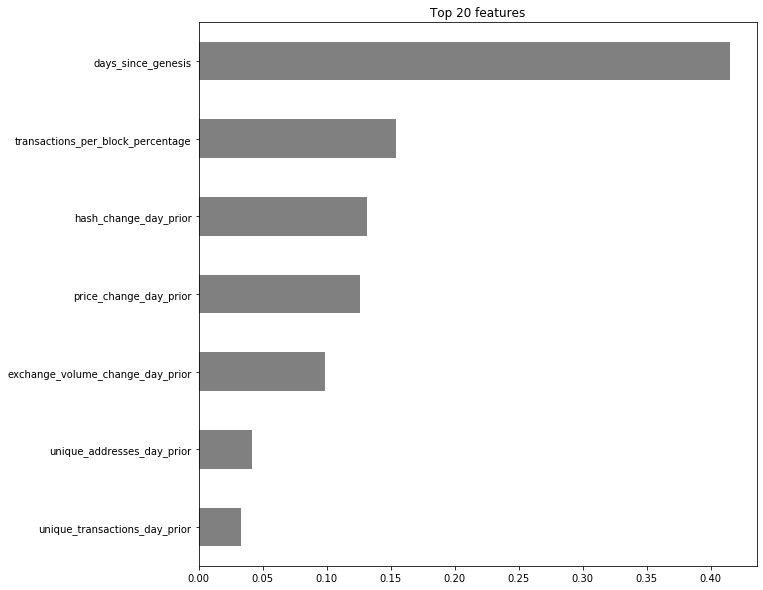

In [25]:
# Get feature importances
rf = model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(bootstrap=True,
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                        max_depth=None,
                                                                        max_features='aut

In [27]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

unique_transactions_day_prior       -0.000548
unique_addresses_day_prior          -0.000548
days_since_genesis                   0.000000
hash_change_day_prior                0.000000
exchange_volume_change_day_prior     0.000000
price_change_day_prior               0.000000
transactions_per_block_percentage    0.000000
dtype: float64

In [28]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0 ± 0.0000,transactions_per_block_percentage
0 ± 0.0000,price_change_day_prior
0 ± 0.0000,exchange_volume_change_day_prior
0 ± 0.0000,hash_change_day_prior
0 ± 0.0000,days_since_genesis
-0.0005 ± 0.0022,unique_addresses_day_prior
-0.0005 ± 0.0022,unique_transactions_day_prior


In [0]:
""" CONFUSION MATRIX """

#Exploration

In [21]:
X_train.head(5)

,days_since_genesis,hash_change_day_prior,exchange_volume_change_day_prior,price_change_day_prior,unique_transactions_day_prior,unique_addresses_day_prior,transactions_per_block_percentage
731,3342,2.840459e+06,1.618150e+08,415.280000,33150.0,58798.0,0.392186
732,3341,4.484936e+06,3.628105e+08,652.010000,41605.0,80184.0,0.377860
733,3340,3.886944e+06,1.957084e+08,1.362667,9665.0,584.0,0.242053
734,3339,4.484936e+05,3.415871e+08,464.160667,30659.0,69281.0,0.304500
735,3338,1.494979e+05,2.385157e+08,231.045000,1958.0,75031.0,0.357515


In [22]:
y_train

731         Costly (200+ cents)
732         Costly (200+ cents)
733         Costly (200+ cents)
734         Costly (200+ cents)
735         Costly (200+ cents)
                 ...           
3471    Negligible (0-10 cents)
3472    Negligible (0-10 cents)
3475    Negligible (0-10 cents)
3482    Negligible (0-10 cents)
3483    Negligible (0-10 cents)
Name: fee, Length: 2690, dtype: object

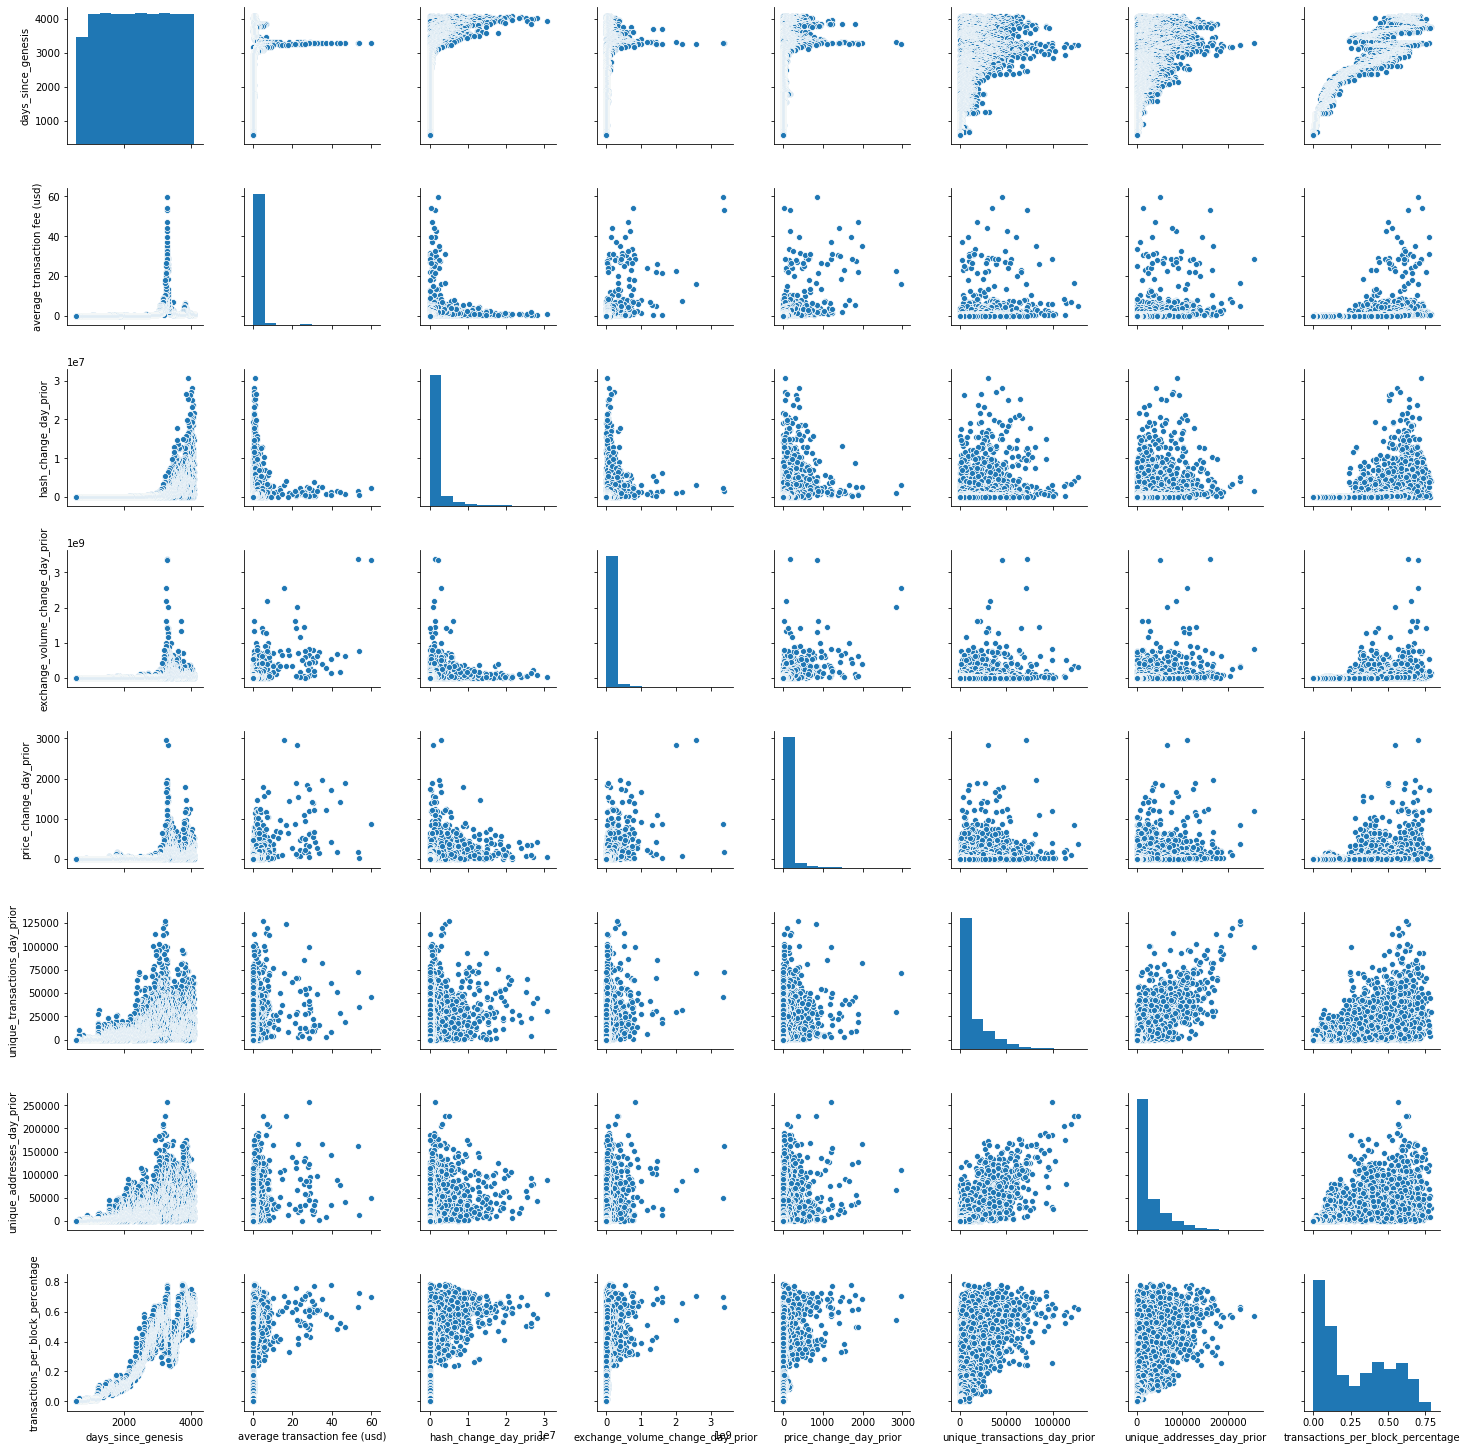

In [23]:
import seaborn as sns

sns.pairplot(df)

In [24]:
df.corr()

,days_since_genesis,average transaction fee (usd),hash_change_day_prior,exchange_volume_change_day_prior,price_change_day_prior,unique_transactions_day_prior,unique_addresses_day_prior,transactions_per_block_percentage
days_since_genesis,1.000000,0.249644,0.551313,0.305028,0.395129,0.537622,0.562225,0.930883
average transaction fee (usd),0.249644,1.000000,0.061497,0.589703,0.548717,0.268510,0.286635,0.307371
hash_change_day_prior,0.551313,0.061497,1.000000,0.145285,0.269093,0.323984,0.292251,0.492733
exchange_volume_change_day_prior,0.305028,0.589703,0.145285,1.000000,0.520080,0.280095,0.301672,0.314787
price_change_day_prior,0.395129,0.548717,0.269093,0.520080,1.000000,0.258472,0.299515,0.387668
unique_transactions_day_prior,0.537622,0.268510,0.323984,0.280095,0.258472,1.000000,0.753259,0.567801
unique_addresses_day_prior,0.562225,0.286635,0.292251,0.301672,0.299515,0.753259,1.000000,0.539262
transactions_per_block_percentage,0.930883,0.307371,0.492733,0.314787,0.387668,0.567801,0.539262,1.000000
